In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from matplotlib import pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.dates as mdates
import joblib

In [4]:
data = pd.read_csv('META-stocks.csv')
data["Date"] = pd.to_datetime(data["Date"])
data["Date"] = pd.to_datetime(data["Date"])

In [5]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close']
target = 'Close'

In [6]:
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
    data[col] = data[col].replace('[\$,]', '', regex=True).astype(float)
for col in ['Volume']:
    data[col] = data[col].replace('[\$,]', '', regex=True).astype(int)

In [7]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [8]:
data.head
data.tail

<bound method NDFrame.tail of            Date        Open        High         Low       Close   Adj Close  \
0    2012-05-18   42.049999   45.000000   38.000000   38.230000   38.084515   
1    2012-05-21   36.529999   36.660000   33.000000   34.029999   33.900501   
2    2012-05-22   32.610001   33.590000   30.940001   31.000000   30.882032   
3    2012-05-23   31.370001   32.500000   31.360001   32.000000   31.878227   
4    2012-05-24   32.950001   33.209999   31.770000   33.029999   32.904308   
...         ...         ...         ...         ...         ...         ...   
3181 2025-01-13  607.099976  608.969971  598.450012  608.330017  608.330017   
3182 2025-01-14  605.070007  605.489990  588.549988  594.250000  594.250000   
3183 2025-01-15  610.210022  622.460022  606.500000  617.119995  617.119995   
3184 2025-01-16  611.500000  616.250000  609.710022  611.299988  611.299988   
3185 2025-01-17  624.049988  624.969971  603.669983  612.770020  612.770020   

         Volume  
0  

In [10]:
#train_end_date = pd.to_datetime("2024-01-01")
#validate_start_date = pd.to_datetime("2024-01-02")
#validate_end_date = pd.to_datetime("2024-12-31")
#test_start_date = pd.to_datetime("2025-01-01")
#test_end_date = pd.to_datetime("2025-08-08")

train_end_date      = pd.to_datetime("2023-12-31")
validate_start_date = pd.to_datetime("2024-01-01")
validate_end_date   = pd.to_datetime("2024-06-30")
test_start_date     = pd.to_datetime("2024-07-01")
test_end_date       = pd.to_datetime("2025-01-17")

data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [11]:
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (2923, 5)
Validation Set: (124, 5)
Testing Set: (139, 5)


In [12]:
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
        Open       High        Low      Close  Adj Close
0  42.049999  45.000000  38.000000  38.230000  38.084515
1  36.529999  36.660000  33.000000  34.029999  33.900501
2  32.610001  33.590000  30.940001  31.000000  30.882032
3  31.370001  32.500000  31.360001  32.000000  31.878227
4  32.950001  33.209999  31.770000  33.029999  32.904308
Validation Dataset:
            Open        High         Low       Close   Adj Close
2923  351.320007  353.160004  340.010010  346.290009  344.972229
2924  344.980011  347.950012  343.179993  344.470001  343.159149
2925  344.500000  348.149994  343.399994  347.119995  345.799042
2926  346.989990  353.500000  346.260010  351.950012  350.610687
2927  354.700012  358.980011  352.049988  358.660004  357.295166
Testing Dataset:
            Open        High         Low       Close   Adj Close
3047  504.950012  506.579987  493.170013  504.679993  503.792633
3048  500.760010  510.500000  499.450012  509.500000  508.604156
3049  506.369995  

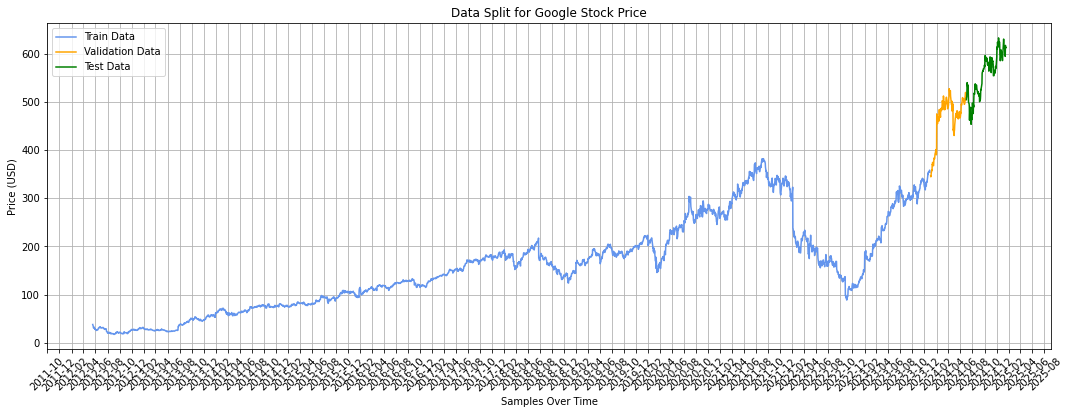

In [13]:
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Close"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Close"], color="orange")
plt.plot(data_test_dates, data_test["Close"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

In [14]:
data[features].describe()

,Open,High,Low,Close,Adj Close
count,3186.000000,3186.000000,3186.000000,3186.000000,3186.000000
mean,186.993983,189.388905,184.632693,187.066114,186.438467
std,132.340763,133.933605,130.660796,132.345106,132.074638
min,18.080000,18.270000,17.549999,17.730000,17.662531
25%,88.697502,89.837500,87.494997,88.410002,88.073563
50%,165.914993,168.315002,163.750000,166.010002,165.378258
75%,246.732498,250.099995,244.490002,246.822506,245.883259
max,631.700012,638.400024,627.210022,632.679993,632.170044


In [15]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

In [16]:
# Prepare scaler model name and location
scaler_model_location = "../Jupyter/models/"
scaler_model_name = "apple_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['../Jupyter/models/apple_stock_price_scaler.gz']

In [17]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.084515,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,33.900501,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,30.882032,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,31.878227,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,32.904308,50237200


In [18]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [19]:
# Prepare datasets files and location
data_file_location = "..//Jupyter//data//processed//"
data_file_name_train = "apple_stock_price_processed_train"
data_file_name_validate = "apple_stock_price_processed_validate"
data_file_name_test = "apple_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)

In [20]:
corr = data.corr()

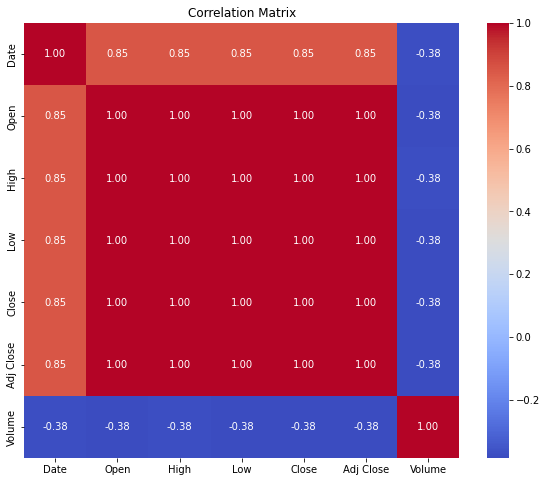

In [21]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()